## What exactly is VCG?

Back in 1950, doctors discovered that it's hard to distinguish between two patients with just their Electrocardiograms - a 2 dimensional plot representing the main heart waves over time to help them diagnose problmes and heart lesions- So they were wodnering if there's a system that accurately shows the electrical activity of the heart and overcome the substantial quantitative defects.

The four main issues Dr.Ernest Frank has addressed in his paper 'An accurate, Clincally Practical System For Spatial Vectrocardiography' were the focus of this system to deal with these errors or removing them completely such as:
1. The Torso Shape
2. Individual Variability in heart location
3. Left Arm Charaterstics
4. Heart Anatomic Oreintation

More about the Vectrocardiography can be found [here](https://www.ahajournals.org/doi/epdf/10.1161/01.CIR.13.5.737)

## Imports & Object Attributes Exploration

In [8]:
import numpy as np # vectorization and complex computations
from scipy import signal as sig # signal preprocessing
import matplotlib.pyplot as plt # for visualization
import wfdb 
# WFDB is used to deal with physiologic signal in biomedical research, and clinical studies.

In [9]:
record = wfdb.rdrecord('02386_lr')
# a core component that represents the contents of a WFDB header file. It is used to read and manipulate WFDB records

In [10]:
record?

Type:        Record
String form: <wfdb.io.record.Record object at 0x00000255A30BC5F0>
File:        c:\users\hp\anaconda3\lib\site-packages\wfdb\io\record.py
Docstring:  
The class representing single segment WFDB records.

Record objects can be created using the initializer, by reading a WFDB
header with `rdheader`, or a WFDB record (header and associated dat files)
with `rdrecord`.

The attributes of the Record object give information about the record as
specified by: https://www.physionet.org/physiotools/wag/header-5.htm

In addition, the d_signal and p_signal attributes store the digital and
physical signals of WFDB records with at least one channel.

Attributes
----------
p_signal : ndarray, optional
    An (MxN) 2d numpy array, where M is the signal length. Gives the
    physical signal values intended to be written. Either p_signal or
    d_signal must be set, but not both. If p_signal is set, this method will
    use it to perform analogue-digital conversion, writing the resulta

In [11]:
dir(record) # returns the attributes and methods of an object

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adjust_datetime',
 '_arrange_fields',
 '_auto_signal_file_names',
 'adc',
 'adc_gain',
 'adc_res',
 'adc_zero',
 'base_counter',
 'base_date',
 'base_datetime',
 'base_time',
 'baseline',
 'block_size',
 'byte_offset',
 'calc_adc_gain_baseline',
 'calc_adc_params',
 'calc_checksum',
 'check_field',
 'check_field_cohesion',
 'check_read_inputs',
 'check_sig_cohesion',
 'checksum',
 'comments',
 'convert_dtype',
 'counter_freq',
 'd_signal',
 'dac',
 'e_d_signal',
 'e_p_signal',
 'file_name',
 'fmt',
 'fs',
 'get_absolute_time',
 'get_elapsed_time',
 'get_frame_number',
 'get_write_fields',
 'get_write_su

In [12]:
fs = record.fs
fs

100

The sampling frequency of the record.

In [13]:
leads = record.sig_name
leads

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

 A list of strings giving the signal name of each signal channel.

In [14]:
signal = record.p_signal
print(f'the signal array:\n{signal}')
print(f'the signal dimensions: \n{record.p_signal.shape}')

the signal array:
[[-0.113 -0.025  0.089 ... -0.022 -0.05  -0.146]
 [-0.109 -0.027  0.082 ... -0.018 -0.047 -0.159]
 [-0.107 -0.02   0.087 ... -0.031 -0.054 -0.171]
 ...
 [ 0.005  0.054  0.048 ... -0.48  -0.032  0.191]
 [-0.089 -0.173 -0.084 ... -0.373 -0.129 -0.025]
 [-0.055 -0.143 -0.088 ... -0.276 -0.092 -0.035]]
the signal dimensions: 
(1000, 12)


A 2d numpy array represents the signal values, where each column represents a lead records

In [15]:
time_vector = np.linspace(0, 10, 1000) # A numpy 1D vector represents the 10-seconds of time sampled 1000 times

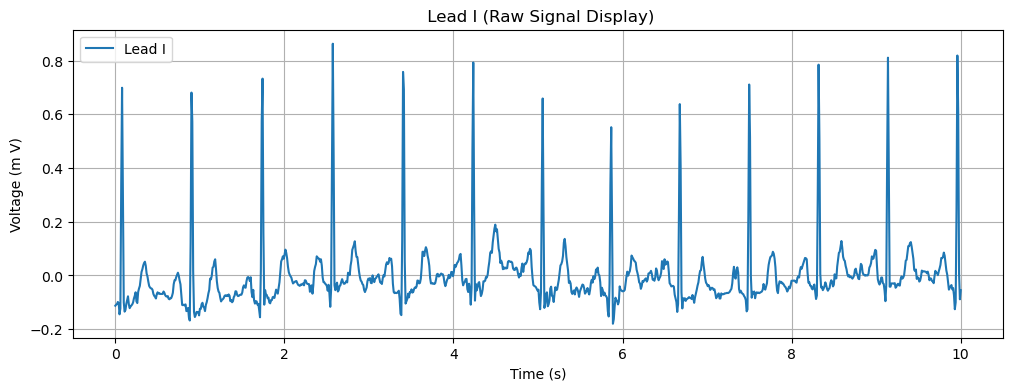

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(time_vector, signal[:, 0], label='Lead I')

plt.title(' Lead I (Raw Signal Display)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (m V)')
plt.grid(True)
plt.legend()
plt.show()

## Signal Preprocessing

In [24]:
def process_ecg_accurate(record):
    
    record = wfdb.rdrecord(record)
    fs = record.fs
    values = record.p_signal

    def highpass_lowpass_ecg_filter(lead_values, fs, cutoff_freq1 = 0.5, cutoff_freq2 = 40, order = 5):
        nyquist_freq = 0.5 * fs
        Wn1 = cutoff_freq1 / nyquist_freq
        Wn2 = cutoff_freq2 / nyquist_freq
        b, a = sig.butter(order, Wn1, btype='highpass', analog=False)
        filtered_lead = sig.filtfilt(b, a, lead_values)
        
        c, d = sig.butter(order, Wn2, btype='lowpass', analog=False)
        filtered_lead = sig.filtfilt(c, d, filtered_lead)
        
        return filtered_lead

    I = highpass_lowpass_ecg_filter(values[:, 0], fs)
    II = highpass_lowpass_ecg_filter(values[:, 1], fs)
    V1 = highpass_lowpass_ecg_filter(values[:, 6], fs)
    V2 = highpass_lowpass_ecg_filter(values[:, 7], fs)
    V3 = highpass_lowpass_ecg_filter(values[:, 8], fs)
    V4 = highpass_lowpass_ecg_filter(values[:, 9], fs)
    V5 = highpass_lowpass_ecg_filter(values[:, 10], fs)
    V6 = highpass_lowpass_ecg_filter(values[:, 11], fs)

    X = -1 * (-0.172 * V1 - 0.074 * V2 + 0.122 * V3 + 0.231 * V4 + 0.239 * V5 + 0.194 * V6 + 0.156 * I - 0.010 * II)
    Y = (0.057 * V1 - 0.019 * V2 - 0.106 * V3 - 0.022 * V4 + 0.041 * V5 + 0.048 * V6 - 0.227 * I + 0.887 * II)
    Z = -1 * (-0.229 * V1 - 0.310 * V2 - 0.246 * V3 - 0.063 * V4 + 0.055 * V5 + 0.108 * V6 + 0.022 * I + 0.102 * II)

    V1 = np.abs(V1) # returns the absolute values of the cleaned V1 signal to find the peaks
    threshold = 0.4 * np.max(V1)
    peaks = sig.find_peaks(x = V1, height = threshold)

    peak = peaks[0][1]

    return X, Y, Z, peak

In [25]:
Xa, Ya, Za, Peak_a = process_ecg_accurate('02386_lr')

In [26]:
loop_xa = Xa[Peak_a-20 : Peak_a+60]
loop_ya = Ya[Peak_a-20 : Peak_a+60]
loop_za = Za[Peak_a-20 : Peak_a+60]

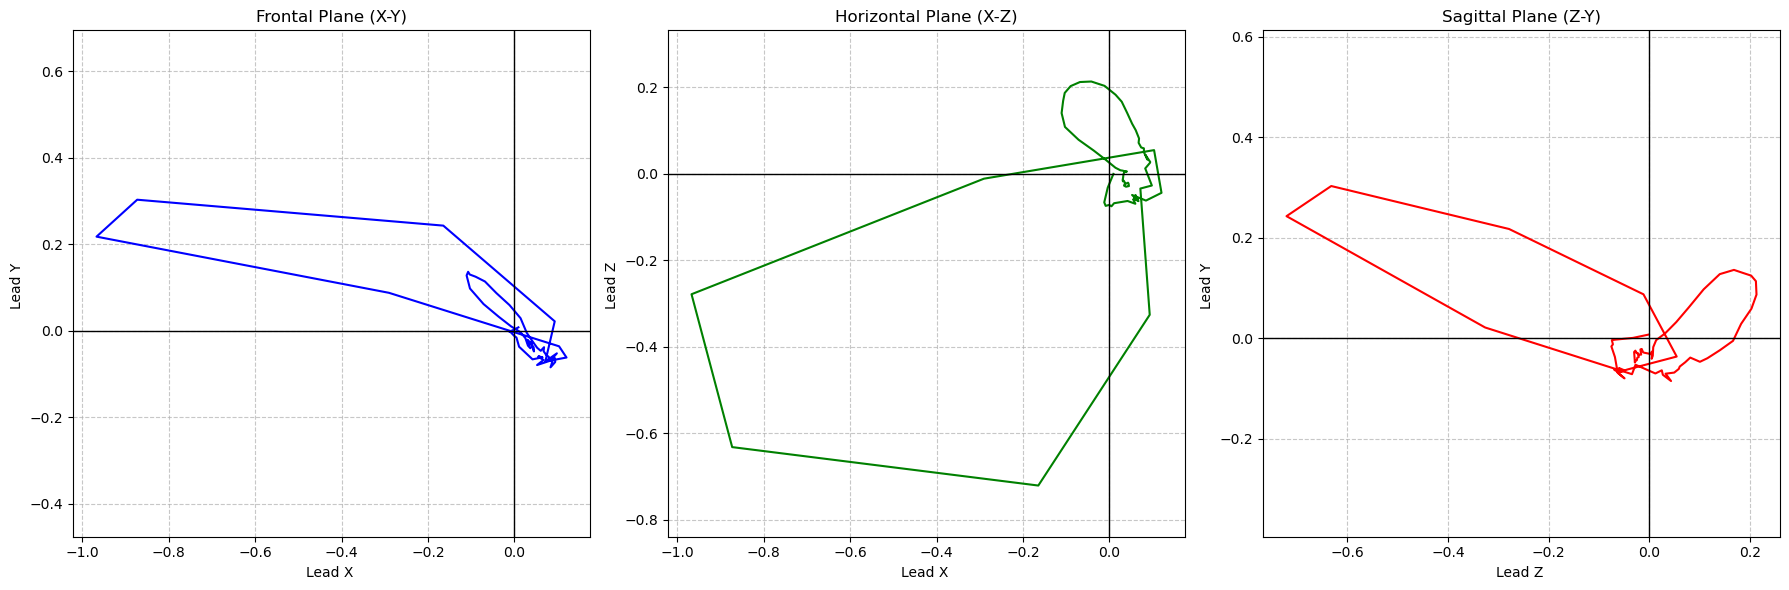

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(loop_xa, loop_ya, color='blue') # Looking from the front
ax1.set_title('Frontal Plane (X-Y)')
ax1.set_xlabel('Lead X ')
ax1.set_ylabel('Lead Y ')

ax2.plot(loop_xa, loop_za, color='green') # Looking from above
ax2.set_title('Horizontal Plane (X-Z)')
ax2.set_xlabel('Lead X ')
ax2.set_ylabel('Lead Z ')

ax3.plot(loop_za, loop_ya, color='red') # Looking from the side
ax3.set_title('Sagittal Plane (Z-Y)')
ax3.set_xlabel('Lead Z ')
ax3.set_ylabel('Lead Y ')

for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', lw=1) 
    ax.axvline(0, color='black', lw=1)


plt.tight_layout()
plt.savefig("VCG_accurate.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(loop1_x, loop1_y, color='blue') # Looking from the front
ax1.set_title('Frontal Plane (X-Y)')
ax1.set_xlabel('Lead X ')
ax1.set_ylabel('Lead Y ')

ax2.plot(loop1_x, loop1_z, color='green') # Looking from above
ax2.set_title('Horizontal Plane (X-Z)')
ax2.set_xlabel('Lead X ')
ax2.set_ylabel('Lead Z ')

ax3.plot(loop1_z, loop1_y, color='red') # Looking from the side
ax3.set_title('Sagittal Plane (Z-Y)')
ax3.set_xlabel('Lead Z ')
ax3.set_ylabel('Lead Y ')

for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', lw=1) 
    ax.axvline(0, color='black', lw=1)


plt.tight_layout()
plt.show()

In [32]:
def process_ecg_record(record_name):
    ''' This function takes raw ECG signal and accomplish four main transformations:
            1) Filtering (Low-pass, and high-pass to eleminate the baseline drift and other forms of noise),
            2) R-peaks detection and RR interval calculation,
            3) It calculates the heart rate,
            4) And lastly it calculates the X, Y, and Z to conduct the 3D Vectrocardiogram afterwards
    '''
    
    record = wfdb.rdrecord(record_name) # Reading the signal and saving it as record.
    fs = record.fs # the sampling frequency
    values = record.p_signal # accessing the 12-lead values through the attribute p_signal and saving them as 'values'.
    raw_V1 = values[:, 6]
    raw_I = values[:, 0]
    raw_aVF = values[:, 5]
    raw_V2 = values[:, 7] # extracting the (V1, I, aVF, and V2) leads' values due to their importance in the upcoming VCG calculations

    def highpass_lowpass_ecg_filter(lead_values, fs, cutoff_freq1 = 0.5, cutoff_freq2 = 40, order = 5):
        """ Applies a low-pass Butterworth filter to the signal to remove the high frequency noise.
            As well as a high-pass Butterworth filter to the signal to remove the baseline drift.
        """
        nyquist_freq = 0.5 * fs
        Wn1 = cutoff_freq1 / nyquist_freq
        Wn2 = cutoff_freq2 / nyquist_freq
        b, a = sig.butter(order, Wn1, btype='highpass', analog=False)
        filtered_lead = sig.filtfilt(b, a, lead_values)
        
        c, d = sig.butter(order, Wn2, btype='lowpass', analog=False)
        filtered_lead = sig.filtfilt(c, d, filtered_lead)
        
        return filtered_lead
    
    V1 = highpass_lowpass_ecg_filter(raw_V1, fs)
    X  = highpass_lowpass_ecg_filter(raw_I, fs)
    Y  = highpass_lowpass_ecg_filter(raw_aVF, fs)
    Z  = highpass_lowpass_ecg_filter(raw_V2, fs)

    V1 = np.abs(V1) # returns the absolute values of the cleaned V1 signal to find the peaks
    threshold = 0.4 * np.max(V1)
    peaks = sig.find_peaks(x = V1, height = threshold) # the find_peaks function returns the "incices" of the peak values of V1
    
    def avg_heart_rate(peaks, fs):
        
        diff = np.diff(peaks[0])
        result = np.divide(np.sum(diff), fs)
        avg_RR_time = result / (len(peaks[0]) - 1)
        heart_rate = 60 / avg_RR_time
        return heart_rate

    Heart_Rate = avg_heart_rate(peaks, fs)
    peak = peaks[0][1]
    
    return  Heart_Rate, peak, X, Y, Z

## VCG

### random sample (100 Hz frequency)

In [33]:
Heart_Rate1, Peak1, X1, Y1, Z1 = process_ecg_record('02386_lr')

In [34]:
print(Heart_Rate1)

72.94832826747721


In [35]:
loop1_x = X1[Peak1-20 : Peak1+60]
loop1_y = Y1[Peak1-20 : Peak1+60]
loop1_z = Z1[Peak1-20 : Peak1+60]

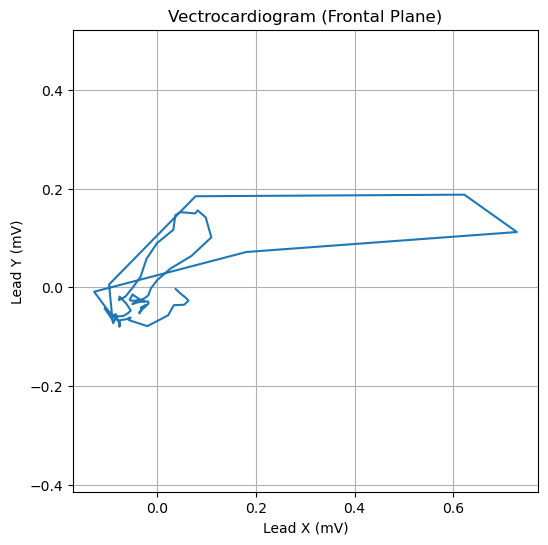

In [36]:
plt.figure(figsize = (6,6))
plt.plot(loop1_x, loop1_y, label = 'Frontal Plane (X-Y)')
plt.axis('equal')

plt.title('Vectrocardiogram (Frontal Plane)')
plt.xlabel('Lead X (mV)')
plt.ylabel('Lead Y (mV)')
plt.grid(True)

plt.show()

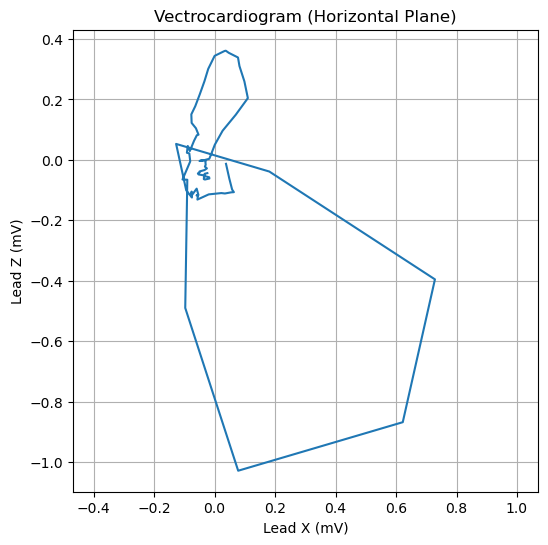

In [37]:
plt.figure(figsize = (6,6))
plt.plot(loop1_x, loop1_z, label = 'Horizontal Plane (X-Z)')
plt.axis('equal')

plt.title('Vectrocardiogram (Horizontal Plane)')
plt.xlabel('Lead X (mV)')
plt.ylabel('Lead Z (mV)')
plt.grid(True)

plt.show()

In [38]:
plt.figure(figsize = (6,6))
plt.plot(loop1_z, loop_y, label = 'Sagittal Plane (Z-Y)')
plt.axis('equal')

plt.title('Vectrocardiogram (Sagittal Plane)')
plt.xlabel('Lead Z (mV)')
plt.ylabel('Lead Y (mV)')
plt.grid(True)

plt.show()

NameError: name 'loop_y' is not defined

<Figure size 600x600 with 0 Axes>

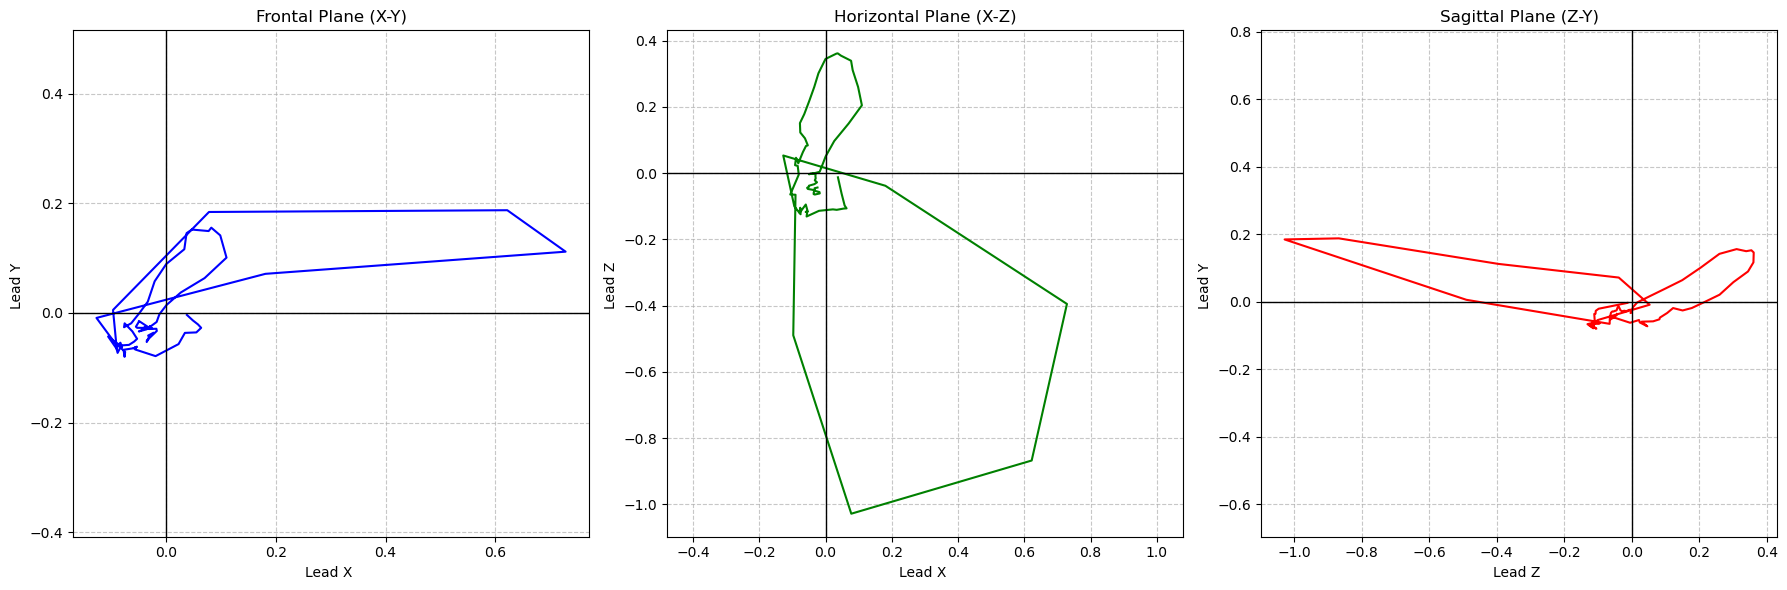

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(loop1_x, loop1_y, color='blue') # Looking from the front
ax1.set_title('Frontal Plane (X-Y)')
ax1.set_xlabel('Lead X ')
ax1.set_ylabel('Lead Y ')

ax2.plot(loop1_x, loop1_z, color='green') # Looking from above
ax2.set_title('Horizontal Plane (X-Z)')
ax2.set_xlabel('Lead X ')
ax2.set_ylabel('Lead Z ')

ax3.plot(loop1_z, loop1_y, color='red') # Looking from the side
ax3.set_title('Sagittal Plane (Z-Y)')
ax3.set_xlabel('Lead Z ')
ax3.set_ylabel('Lead Y ')

for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', lw=1) 
    ax.axvline(0, color='black', lw=1)


plt.tight_layout()
plt.savefig("VCG not very accurate.png", dpi=300, bbox_inches="tight")
plt.show()

### Random Sample (500 Hz frequency)

In [39]:
Heart_Rate2, Peak2, X2, Y2, Z2 = process_ecg_record('21000_hr')

In [40]:
print(Heart_Rate2)

116.95906432748538


In [41]:
loop2_x = X2[Peak2-20 : Peak2+60]
loop2_y = Y2[Peak2-20 : Peak2+60]
loop2_z = Z2[Peak2-20 : Peak2+60]

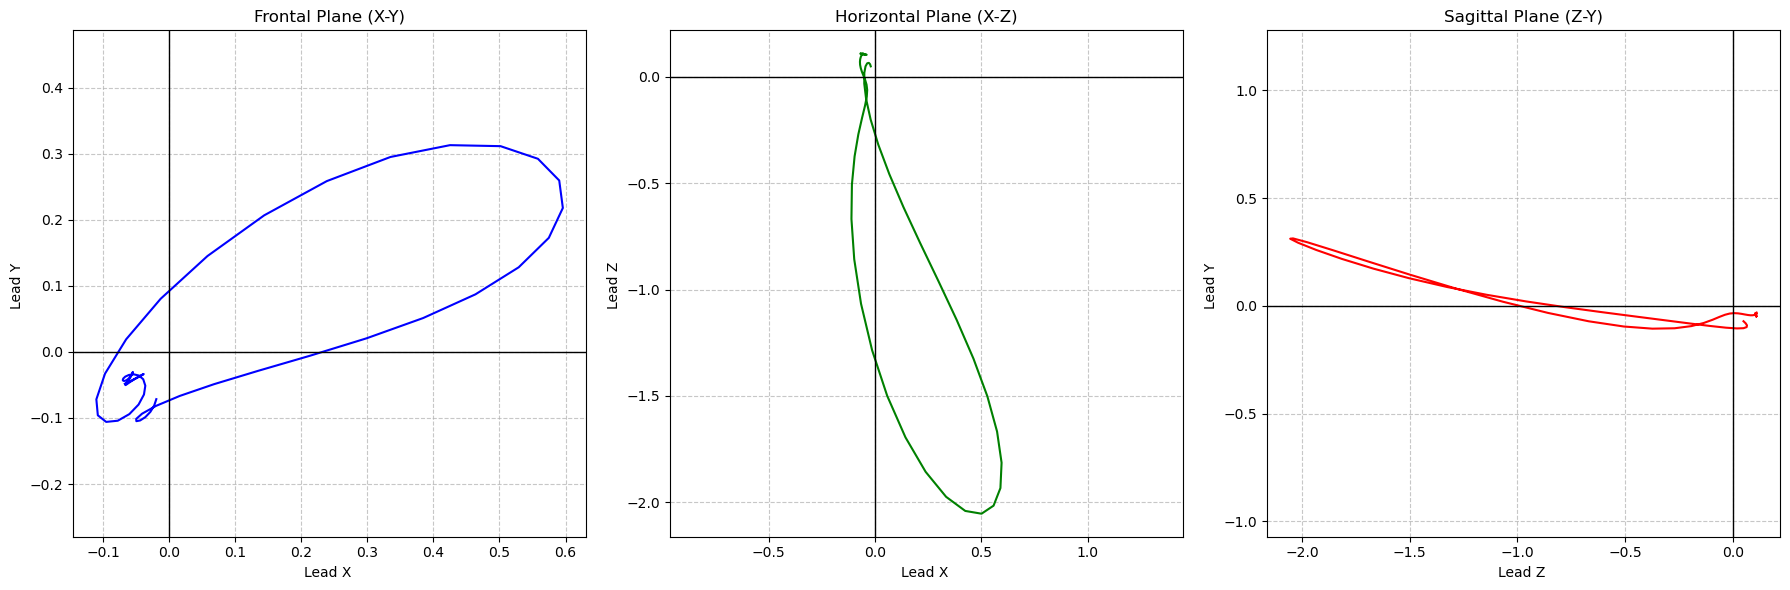

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(loop2_x, loop2_y, color='blue') # Looking from the front
ax1.set_title('Frontal Plane (X-Y)')
ax1.set_xlabel('Lead X ')
ax1.set_ylabel('Lead Y ')

ax2.plot(loop2_x, loop2_z, color='green') # Looking from above
ax2.set_title('Horizontal Plane (X-Z)')
ax2.set_xlabel('Lead X ')
ax2.set_ylabel('Lead Z ')

ax3.plot(loop2_z, loop2_y, color='red') # Looking from the side
ax3.set_title('Sagittal Plane (Z-Y)')
ax3.set_xlabel('Lead Z ')
ax3.set_ylabel('Lead Y ')

for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', lw=1) 
    ax.axvline(0, color='black', lw=1)


plt.tight_layout()
plt.show()

### Two more signals

In [43]:
Heart_Rate3, Peak3, X3, Y3, Z3 = process_ecg_record('04809_lr')

In [44]:
print(Heart_Rate3)

80.32955715756951


In [45]:
loop3_x = X3[Peak3-20 : Peak3+60]
loop3_y = Y3[Peak3-20 : Peak3+60]
loop3_z = Z3[Peak3-20 : Peak3+60]

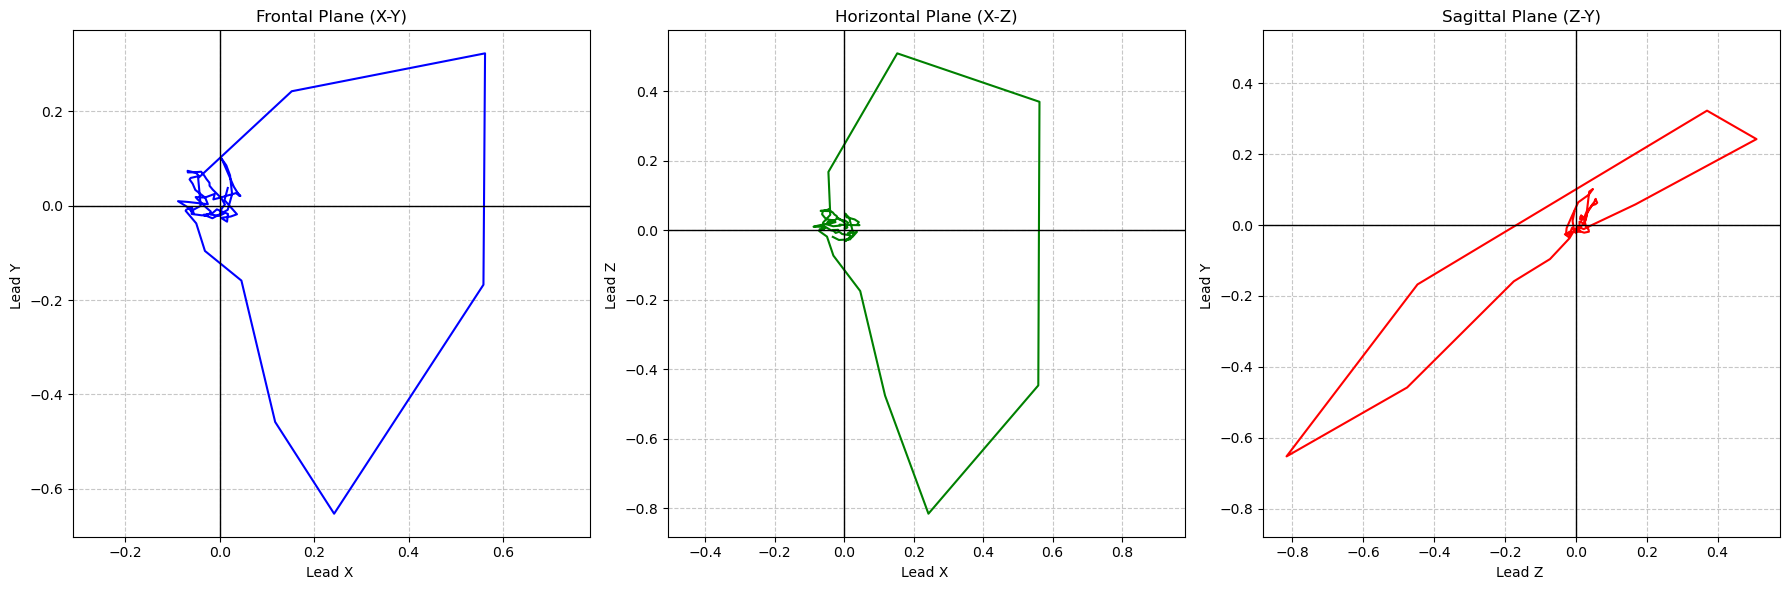

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(loop3_x, loop3_y, color='blue') # Looking from the front
ax1.set_title('Frontal Plane (X-Y)')
ax1.set_xlabel('Lead X ')
ax1.set_ylabel('Lead Y ')

ax2.plot(loop3_x, loop3_z, color='green') # Looking from above
ax2.set_title('Horizontal Plane (X-Z)')
ax2.set_xlabel('Lead X ')
ax2.set_ylabel('Lead Z ')

ax3.plot(loop3_z, loop3_y, color='red') # Looking from the side
ax3.set_title('Sagittal Plane (Z-Y)')
ax3.set_xlabel('Lead Z ')
ax3.set_ylabel('Lead Y ')

for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', lw=1) 
    ax.axvline(0, color='black', lw=1)


plt.tight_layout()
plt.show()

In [49]:
Heart_Rate4, Peak4, X4, Y4, Z4 = process_ecg_record('10000_hr')

print(Heart_Rate4)

loop4_x = X4[Peak4-20 : Peak4+60]
loop4_y = Y4[Peak4-20 : Peak4+60]
loop4_z = Z4[Peak4-20 : Peak4+60]

58.87483645878762


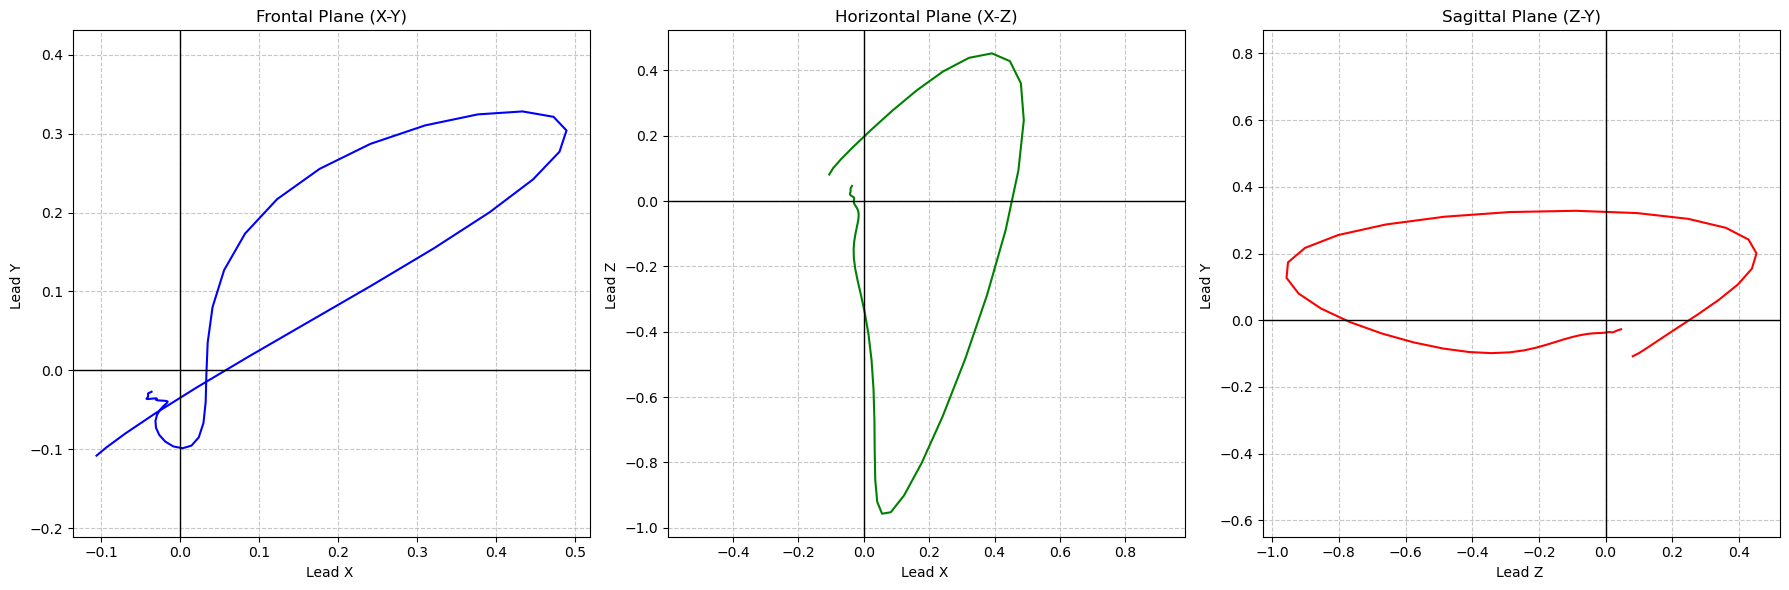

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.plot(loop4_x, loop4_y, color='blue') # Looking from the front
ax1.set_title('Frontal Plane (X-Y)')
ax1.set_xlabel('Lead X ')
ax1.set_ylabel('Lead Y ')

ax2.plot(loop4_x, loop4_z, color='green') # Looking from above
ax2.set_title('Horizontal Plane (X-Z)')
ax2.set_xlabel('Lead X ')
ax2.set_ylabel('Lead Z ')

ax3.plot(loop4_z, loop4_y, color='red') # Looking from the side
ax3.set_title('Sagittal Plane (Z-Y)')
ax3.set_xlabel('Lead Z ')
ax3.set_ylabel('Lead Y ')

for ax in [ax1, ax2, ax3]:
    ax.axis('equal') 
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.axhline(0, color='black', lw=1) 
    ax.axvline(0, color='black', lw=1)


plt.tight_layout()
plt.show()

## Citations & References

1. [wfdb package](https://wfdb.io/)
2. [Object Attributes](https://wfdb.readthedocs.io/en/latest/wfdb.html)
3. [Signal header Format](https://www.physionet.org/physiotools/wag/header-5.htm)
4. [Vectrocardiography](https://en.wikipedia.org/wiki/Vectorcardiography)
5. [An Accurate, Clinically Practical System For Spatial Vectrocardiography](https://www.ahajournals.org/doi/epdf/10.1161/01.CIR.13.5.737)
7. [The History Of Vectrocardiography](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/615FA6E1D651C3EB20AD0E5FCE8039B8/S002572730007054Xa.pdf/div-class-title-the-history-of-vectorcardiography-a-href-fn01-ref-type-fn-a-div.pdf)